# Optimizing Marginal Revenue from the Demand Curve, Kaggle

## Load data

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/retail_price.csv') \
    .assign(
        month_year=lambda d: pd.to_datetime(d['month_year']),
        year=lambda d: d['month_year'].dt.year,
        month=lambda d: d['month_year'].dt.month,
        weekend=lambda d: d['weekday'].apply(lambda x: 1 if x >= 5 else 0),
        text=lambda d: d['product_category_name'].apply(lambda s: ' '.join(s.split('_')))
    )
df.shape

(676, 31)

## Product categories

In [2]:
df.rename(columns={'product_category_name': 'category'}) \
    .groupby(['category', 'unit_price']) \
    .size() \
    .reset_index() \
    .groupby(['category']) \
    .size()

category
bed_bath_table           26
computers_accessories    48
consoles_games           10
cool_stuff               18
furniture_decor          13
garden_tools             56
health_beauty            33
perfumery                14
watches_gifts            78
dtype: int64

## Demand curves by category and price

In [3]:
pq_df = df.groupby(['product_category_name', 'unit_price']) \
    .agg(
        q=pd.NamedAgg('qty', 'sum')
    ) \
    .reset_index() \
    .rename(columns={'unit_price': 'p', 'product_category_name': 'category'}) \
    .set_index(['category']) \
    .join(df \
        .rename(columns={'product_category_name': 'category'}) \
        .groupby(['category']) \
        .agg(c=pd.NamedAgg('freight_price', 'mean'))
    )
pq_df.shape

(296, 3)

## Optimal prices

In [4]:
from sklearn.linear_model import LinearRegression

def get_mc(category):
    return pq_df[pq_df.index==category].iloc[0].c

def get_Xy(category):
    Xy = pq_df[pq_df.index==category]
    X = Xy[['p']]
    y = Xy['q']
    
    return X, y

def get_model(X, y):
    m = LinearRegression()
    m.fit(X, y)
    
    return m

def debug_params(model, mc):
    b_0, b_1 = model.intercept_, model.coef_[0]
    qp_params = f'{b_0:.5f} + {b_1:.5f}p'
    
    z_0, z_1 = (-b_0 / b_1), (1 / b_1)
    pq_params = f'{z_0:.5f} + {z_1:.5f}q'
    tr_params = f'{z_0:.5f}q + {z_1:.5f}q^2'
    
    z_0, z_1 = (-b_0 / b_1), 2 * (1 / b_1)
    mr_params = f'{z_0:.5f} + {z_1:.5f}q'
    
    z_0, z_1 = (-b_0 / b_1), 2 * (1 / b_1)
    qo_params = f'({mc:.5f} - {z_0:.5f}) / {z_1:.5f}'
    
    return {
        'q': qp_params,
        'p': pq_params,
        'tr': tr_params,
        'mr': mr_params,
        'qo': qo_params
    }
    
def get_params(model):
    return pd.Series([model.intercept_, model.coef_[0]], ['b_0', 'b_1'])

def get_pq(b_0, b_1):
    return lambda q: (-b_0 / b_1) + (1 / b_1) * q

def get_qp(b_0, b_1):
    return lambda p: b_0 + (b_1 * p)

def get_mr(b_0, b_1):
    return lambda q: (-b_0 / b_1) + (2 * (1 / b_1) * q)

def get_qo(b_0, b_1):
    z_0 = (-b_0 / b_1)
    z_1 = 2 * (1 / b_1)
    return lambda mc: (mc - z_0) / z_1

def get_funcs(b_0, b_1):
    pq = get_pq(b_0, b_1)
    qp = get_qp(b_0, b_1)
    mr = get_mr(b_0, b_1)
    qo = get_qo(b_0, b_1)
    r = lambda p, q: p * q
    t = lambda p, q, mc: (p * q) - (mc * q)
    
    return pq, qp, mr, qo, r, t

def get_opt(f, mc):
    pq_f, qp_f, mr_f, qo_f, r_f, t_f = f
    
    q_opt = qo_f(mc)
    p_opt = pq_f(q_opt)
    mr_opt = mr_f(q_opt)
    r_opt = r_f(p_opt, q_opt)
    t_opt = t_f(p_opt, q_opt, mc)

    return pd.Series({
        'mc': mc,
        'p': p_opt,
        'q': q_opt,
        'mr': mr_opt,
        'tr': r_opt,
        'pr': t_opt
    })

def optimize(category):
    X, y = get_Xy(category)
    m = get_model(X, y)
    p = get_params(m)
    f = get_funcs(p.b_0, p.b_1)
    mc = get_mc(category)
    
    return {**{'category': category}, **get_opt(f, mc).to_dict()}

In [5]:
opt_df = pd.DataFrame([optimize(c) for c in pq_df.index.unique()])
opt_df

,category,mc,p,q,mr,tr,pr
0,bed_bath_table,16.139718,413.954170,21.954253,16.139718,9088.054630,8733.719184
1,computers_accessories,25.103741,-27.221815,6.479547,25.103741,-176.385023,-339.045890
2,consoles_games,14.809415,26.068586,30.257496,14.809415,788.770143,340.674335
3,cool_stuff,18.975096,151.269261,24.424237,18.975096,3694.636306,3231.184067
4,furniture_decor,16.944617,222.175809,38.990538,16.944617,8662.754232,8002.074509
5,garden_tools,28.458310,99.268009,36.931818,28.458310,3666.148045,2615.130919
6,health_beauty,18.607448,849.975469,29.792779,18.607448,25323.131451,24768.763874
7,perfumery,14.336311,78.183209,30.772484,14.336311,2405.891570,1964.727677
8,watches_gifts,16.492840,159.459065,21.486980,16.492840,3426.293739,3071.912418


## Visualizing optimal prices

In [6]:
import matplotlib.pyplot as plt

def plot_rev_profit_curves(category, min_p=1, max_p=800, ax=None):
    X, y = get_Xy(category)
    m = get_model(X, y)
    p = get_params(m)
    f = get_funcs(p.b_0, p.b_1)
    mc = get_mc(category)
    opt = get_opt(f, mc)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))
    else:
        fig = None

    pd.DataFrame({
        'p': np.arange(min_p, max_p + 1, 1),

    }).assign(
        q=lambda d: f[1](d['p']),
        tr=lambda d: d['p'] * d['q'],
        mr=lambda d: f[2](d['q']),
        pr=lambda d: f[5](d['p'], d['q'], mc)
    ) \
    .set_index(['p'])[['tr', 'pr']] \
    .plot(kind='line', ax=ax)
    
    ax.axvline(x=opt.p, color='r', alpha=0.5, linestyle='dotted')
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    ax.set_title(f'{category}, p_opt=${opt.p:.2f}')
    ax.set_ylabel('USD')
    
    if fig is not None:
        fig.tight_layout()

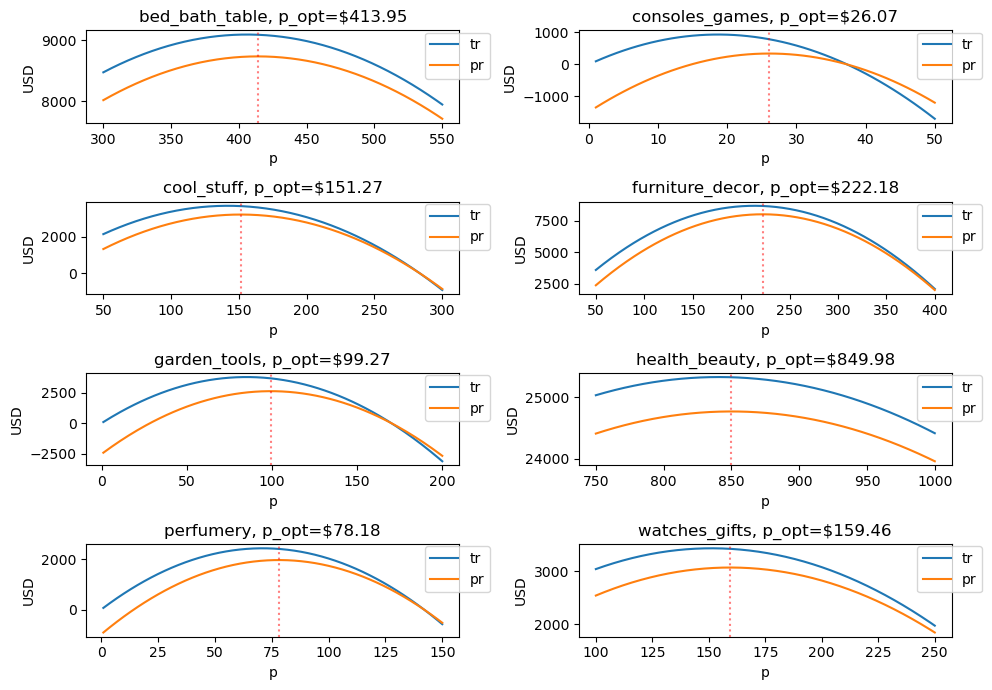

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(10, 7))

categories = [
    'bed_bath_table', 'consoles_games', 'cool_stuff', 'furniture_decor',
    'garden_tools', 'health_beauty', 'perfumery', 'watches_gifts'
]
min_p = [
    300, 1, 50, 50,
    1, 750, 1, 100
]
max_p = [
    550, 50, 300, 400,
    200, 1_000, 150, 250
]

for c, _min_p, _max_p, ax in zip(categories, min_p, max_p, np.ravel(axes)):
    plot_rev_profit_curves(c, min_p=_min_p, max_p=_max_p, ax=ax)

fig.tight_layout()

## Computer accessories

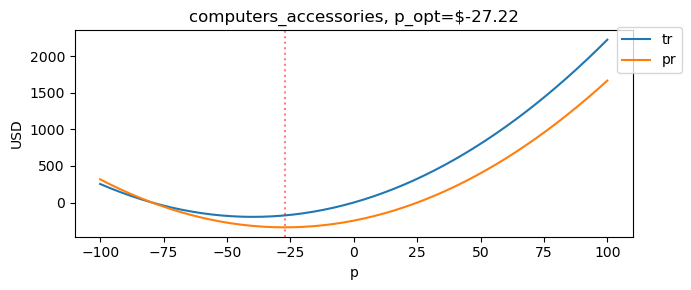

In [8]:
plot_rev_profit_curves('computers_accessories', min_p=-100, max_p=100)

In [9]:
category = 'computers_accessories'
X, y = get_Xy(category)
m = get_model(X, y)
p = get_params(m)
f = get_funcs(p.b_0, p.b_1)
mc = get_mc(category)
opt = get_opt(f, mc)

In [10]:
opt

mc     25.103741
p     -27.221815
q       6.479547
mr     25.103741
tr   -176.385023
pr   -339.045890
dtype: float64

In [11]:
debug_params(m, mc)

{'q': '9.85046 + 0.12383p',
 'p': '-79.54737 + 8.07550q',
 'tr': '-79.54737q + 8.07550q^2',
 'mr': '-79.54737 + 16.15099q',
 'qo': '(25.10374 - -79.54737) / 16.15099'}

/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


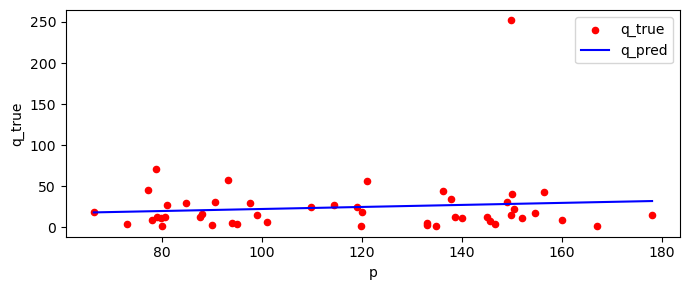

In [12]:
fig, ax = plt.subplots(figsize=(7, 3))

_temp = pq_df[pq_df.index==category] \
    .assign(
        q_true=lambda d: d['q'],
        q_pred=lambda d: f[1](d['p'])
    )[['p', 'q_true', 'q_pred']]

_temp.plot(kind='scatter', x='p', y='q_true', label='q_true', ax=ax, color='r')
_temp.plot(kind='line', x='p', y='q_pred', label='q_pred', ax=ax, color='b')

fig.tight_layout()

## Remove outlier

In [15]:
Xy = pq_df[pq_df.index==category].query('q < 252')
X = Xy[['p']]
y = Xy['q']

m = get_model(X, y)
p = get_params(m)
f = get_funcs(p.b_0, p.b_1)
mc = get_mc(category)
opt = get_opt(f, mc)

In [16]:
opt

mc      25.103741
p      280.092646
q       11.847662
mr      25.103741
tr    3318.442913
pr    3021.022281
dtype: float64

In [17]:
debug_params(m, mc)

{'q': '24.86173 + -0.04646p',
 'p': '535.08155 + -21.52230q',
 'tr': '535.08155q + -21.52230q^2',
 'mr': '535.08155 + -43.04460q',
 'qo': '(25.10374 - 535.08155) / -43.04460'}

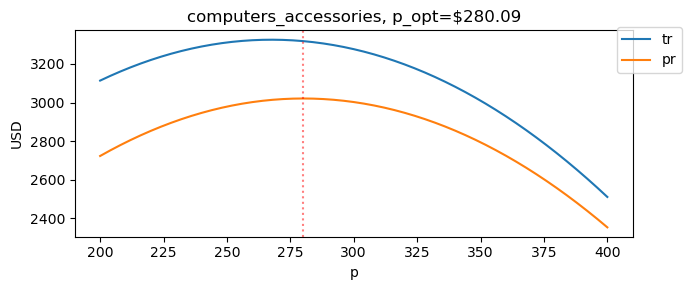

In [21]:
min_p, max_p = 200, 400

fig, ax = plt.subplots(figsize=(7, 3))

pd.DataFrame({
    'p': np.arange(min_p, max_p + 1, 1),

}).assign(
    q=lambda d: f[1](d['p']),
    tr=lambda d: d['p'] * d['q'],
    mr=lambda d: f[2](d['q']),
    pr=lambda d: f[5](d['p'], d['q'], mc)
) \
.set_index(['p'])[['tr', 'pr']] \
.plot(kind='line', ax=ax)

ax.axvline(x=opt.p, color='r', alpha=0.5, linestyle='dotted')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_title(f'{category}, p_opt=${opt.p:.2f}')
ax.set_ylabel('USD')

fig.tight_layout()